In [9]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob

from utils.plotter import Plotter
from utils.data_handler import DataHandler

labels = ["enkf"]
root = lambda x, y: f"./output_{x}/work{y}/"
n_works = len(glob(root(labels[0], "*")))
template = lambda x, y: f"{root(x, y)}/output/"
data_folder = lambda x: template(labels[0], x)
noise_file = lambda x: f"{root(labels[0], x)}/airpressure_noise.nc"
folder = data_folder(0)
output_folder = "figs"

start_date = "2014-06-01"
end_date = "2014-08-31"
noos_folder = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochObserver/noos_cmems"
noos_file = lambda station: os.path.join(noos_folder, f"timeseries_{start_date}_{end_date}_{station}_averaged.noos")
locs_file = "/home/mverlaan/einf220/fromDavid/gtsm_openDA_david/stochModel/input_dflowfm/grid_locs.xyn"
xs, ys, stations = DataHandler.read_xyn(locs_file)

his_file = "full_gtsm_fine_0000_his.nc"
av_file = "full_gtsm_fine_averaged_0000_his.nc"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
for i in range(n_works):
    nc = xr.load_dataset(noise_file(i))
    nc.interp(y=52.9, x=4.7).p.plot(label=f"{i}")

<Figure size 640x480 with 0 Axes>

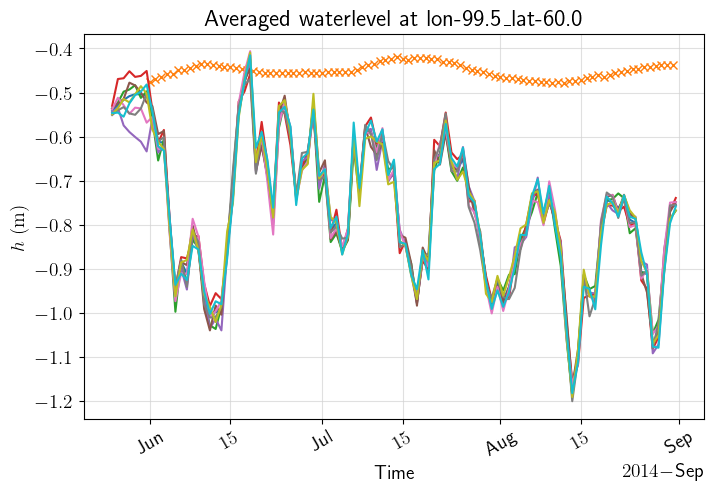

<Figure size 640x480 with 0 Axes>

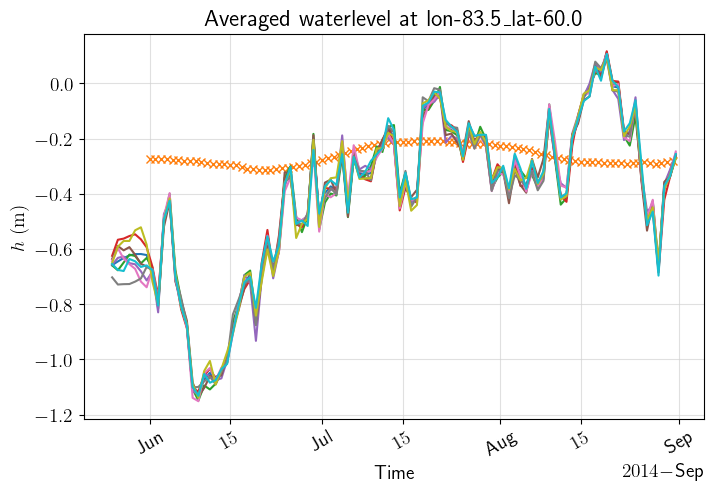

<Figure size 640x480 with 0 Axes>

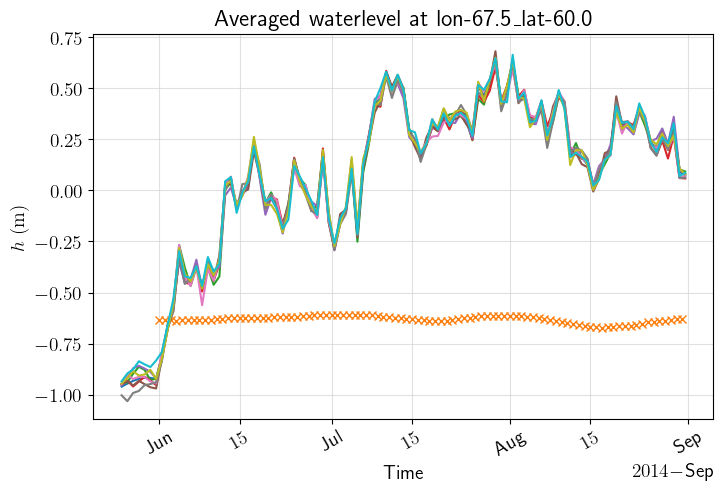

<Figure size 640x480 with 0 Axes>

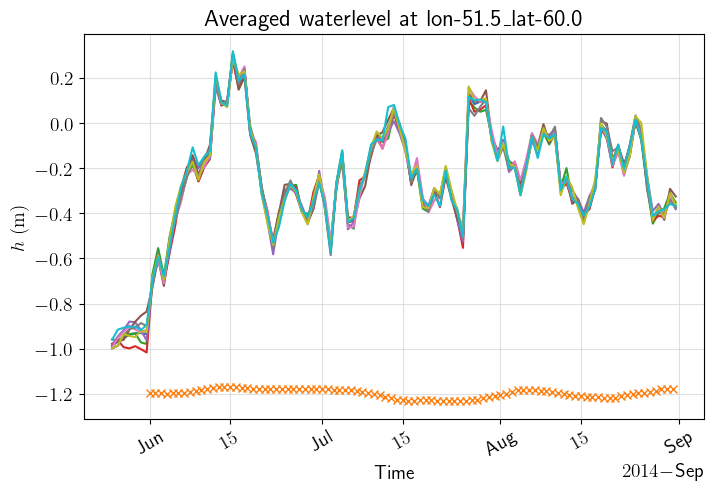

<Figure size 640x480 with 0 Axes>

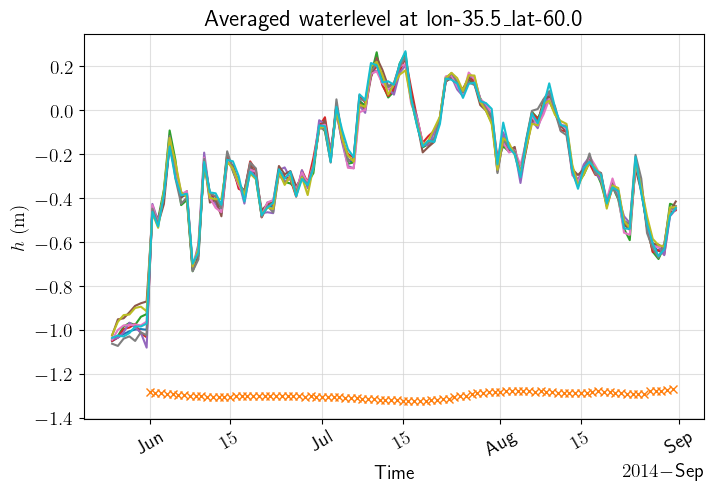

<Figure size 640x480 with 0 Axes>

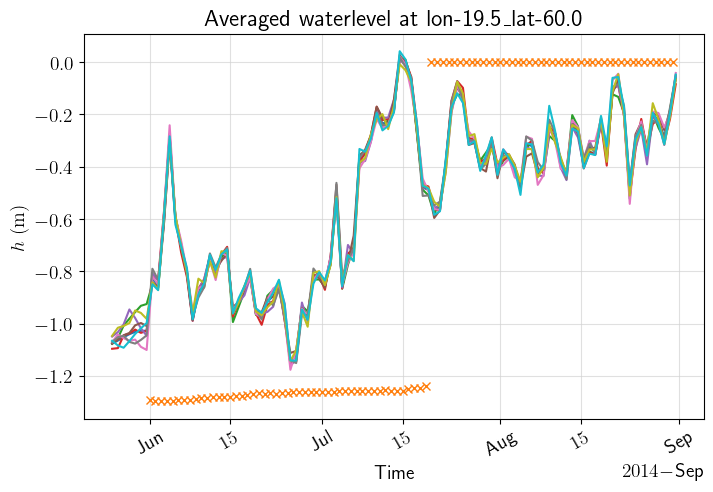

In [10]:
for station in stations[5:11]:
    title_func = lambda s: f"Averaged waterlevel at {s}"
    ts = []
    ws = []
    works = list(range(n_works))
    works = [str(x) for x in works]
    for work in works:
        file = os.path.join(data_folder(work), av_file)
        nc_his = xr.load_dataset(file)

        stations_his = nc_his.station_name.values
        stations_his = np.array([s.decode("utf-8").strip() for s in stations_his])
        nc_his["station_name"] = ("stations", stations_his)
        station_data = nc_his.where(nc_his.station_name == station).dropna("stations")

        ts.append(station_data.time)
        loc_name = station
        ws.append(station_data.waterlevel.values.squeeze())

    # Observations
    obs_ts, obs = DataHandler.read_noos(noos_file(station))
    observations = [obs_ts, obs]
    Plotter.plot_series(
        ts,
        ws,
        loc_name,
        title_func,
        obs_data=observations,
    )
    plt.show()

In [ ]:
station_data

In [ ]:
stations_his = nc_his.station_name.values
stations_his = np.array([s.decode("utf-8").strip() for s in stations_his])
nc_his.coords["station_name"] = stations_his
nc_his

In [ ]:
nc_his.where(nc_his.station_name == stations[0]).dropna("stations")

In [ ]:
from datetime import datetime, timedelta, timezone

files = glob("./algorithm/*/*.nc")
data_files = [xr.open_dataset(file) for file in files]
ncs = []
times = []
for file in files:
    nc = xr.load_dataset(file)
    time = pd.to_datetime(datetime(1858, 11, 17)) + nc.time_stamp.values[0]
    nc["time_stamp"] = time
    ncs.append(nc)
    times.append(time)

nc = xr.concat(ncs, pd.Index(times, name="time"))
nc = nc.rename_dims({"station_dimension": "stations"})
nc.isel(stations=0).s1[:, 0].plot()